# **Downloading the dataset**

In [1]:
# Step 1: Upload your kaggle.json
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"junaidio","key":"9df7569d548494063e8d0319c9609f58"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98% 1.31G/1.33G [00:12<00:00, 193MB/s]
100% 1.33G/1.33G [00:12<00:00, 117MB/s]


In [4]:
!unzip -q celeba-dataset.zip 'img_align_celeba/*' -d celeba_data

## Importing the libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cv2
import os
import time
from tqdm import tqdm
from torch.utils.data import Dataset
import torch.nn as nn
from PIL import Image

# Creating Dataset and Dataloader

In [18]:
class CelebADataset:
    def __init__(self, folder_path, limit=60000, img_size=128):# we will use only 60k images
        self.img_size = img_size
        self.folder_path = folder_path
        self.file_names = os.listdir(folder_path)[:limit]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        img_path = os.path.join(self.folder_path, img_name)


        X = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        X = cv2.resize(X, (self.img_size, self.img_size))
        X = X.astype('float32') / 255.0
        X = X.reshape(1, self.img_size, self.img_size)


        y = cv2.imread(img_path)[:, :, ::-1]
        y = cv2.resize(y, (self.img_size, self.img_size))
        y = y.astype('float32') / 255.0
        y = y.transpose(2, 0, 1)

        return X, y
folder_path = r"/content/celeba_data/img_align_celeba/img_align_celeba"
dataset = CelebADataset(folder_path=folder_path, limit=60000, img_size=128)

In [19]:
X_sample, y_sample = dataset[0]
print(f"Grayscale image shape: {X_sample.shape}")
print(f"Color image shape: {y_sample.shape}")

Grayscale image shape: (1, 128, 128)
Color image shape: (3, 128, 128)


In [20]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
a, b = next(iter(train_loader))
a.shape, b.shape

(torch.Size([64, 1, 128, 128]), torch.Size([64, 3, 128, 128]))

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Autoencoder Neural Network

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(

            nn.Conv2d(1, 64, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 1024, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, (3,3), stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x


In [23]:
model = Autoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training Loop

In [24]:
epochs = 30
train_losses = []

for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0

    for gray, col in tqdm(train_loader):
        # Move data to GPU
        gray = gray.to(device)
        col = col.to(device)

        # Forward pass
        outputs = model(gray)
        loss = criterion(outputs, col)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    # Print epoch results
    avg_loss = total_epoch_loss / len(train_loader)
    print(f"EPOCH: {epoch+1}, LOSS: {avg_loss}")
    train_losses.append(avg_loss)

100%|██████████| 938/938 [03:30<00:00,  4.47it/s]


EPOCH: 1, LOSS: 0.013460561844097304


100%|██████████| 938/938 [03:30<00:00,  4.46it/s]


EPOCH: 2, LOSS: 0.008742497270323162


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


EPOCH: 3, LOSS: 0.0076984412817240775


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 4, LOSS: 0.007193793119715729


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 5, LOSS: 0.006829559516066364


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 6, LOSS: 0.006547357209884663


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 7, LOSS: 0.0063081127407748116


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 8, LOSS: 0.006065706409184314


100%|██████████| 938/938 [03:30<00:00,  4.47it/s]


EPOCH: 9, LOSS: 0.005792311261664194


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


EPOCH: 10, LOSS: 0.005470790893836284


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 11, LOSS: 0.005118481886845185


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 12, LOSS: 0.004812027928657703


100%|██████████| 938/938 [03:30<00:00,  4.47it/s]


EPOCH: 13, LOSS: 0.004527909342876709


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 14, LOSS: 0.0043109032848695


100%|██████████| 938/938 [03:33<00:00,  4.40it/s]


EPOCH: 15, LOSS: 0.004123229470634177


100%|██████████| 938/938 [03:34<00:00,  4.38it/s]


EPOCH: 16, LOSS: 0.0039570637653941225


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 17, LOSS: 0.0038146508005219323


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 18, LOSS: 0.003715823768133691


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


EPOCH: 19, LOSS: 0.0036374962196619844


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


EPOCH: 20, LOSS: 0.0034804968337125296


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


EPOCH: 21, LOSS: 0.0033932740776253536


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


EPOCH: 22, LOSS: 0.0032998947285191177


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


EPOCH: 23, LOSS: 0.003243108816903585


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


EPOCH: 24, LOSS: 0.00317902662488483


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 25, LOSS: 0.0031004235560972014


100%|██████████| 938/938 [03:29<00:00,  4.49it/s]


EPOCH: 26, LOSS: 0.0030369158066721803


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 27, LOSS: 0.0029843763650845745


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


EPOCH: 28, LOSS: 0.002933165781559355


100%|██████████| 938/938 [03:30<00:00,  4.47it/s]


EPOCH: 29, LOSS: 0.002888654514070926


100%|██████████| 938/938 [03:30<00:00,  4.46it/s]

EPOCH: 30, LOSS: 0.002834218906175131


# Evaluating The Model Performance With PSNR  and SSIM

In [31]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    psnr_total = 0
    ssim_total = 0
    count = 0

    with torch.no_grad():
        for gray, col in dataloader:
            gray, col = gray.to(device), col.to(device)
            output = model(gray)

            for i in range(output.size(0)):
                pred_img = output[i].cpu().numpy().transpose(1, 2, 0)
                true_img = col[i].cpu().numpy().transpose(1, 2, 0)

                pred_img = np.clip(pred_img, 0, 1)
                true_img = np.clip(true_img, 0, 1)

                psnr_val = psnr(true_img, pred_img, data_range=1.0)
                ssim_val = ssim(true_img, pred_img, data_range=1.0, channel_axis=-1, win_size=7)

                psnr_total += psnr_val
                ssim_total += ssim_val
                count += 1

    avg_psnr = psnr_total / count
    avg_ssim = ssim_total / count

    print(f"✅ Evaluation — PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim



In [32]:
evaluate_model(model, train_loader, device)


✅ Evaluation — PSNR: 25.74, SSIM: 0.8178


(np.float64(25.73637241131522), np.float32(0.8177683))

# Tracking The Model Loss

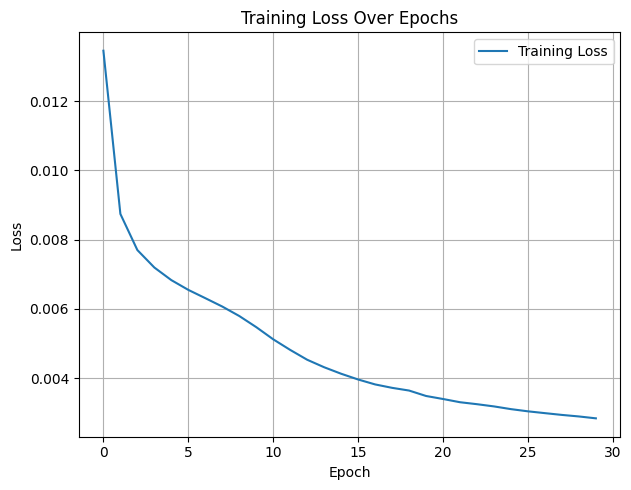

In [25]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Quick Test of the model

In [26]:
model.eval()
with torch.no_grad():
    gray, col = next(iter(train_loader))
    gray = gray.to(device)
    outputs = model(gray)
    gray = gray.cpu()
    outputs = outputs.cpu()
    plt.figure(figsize=(15, 6))
    num_samples = 5

<Figure size 1500x600 with 0 Axes>

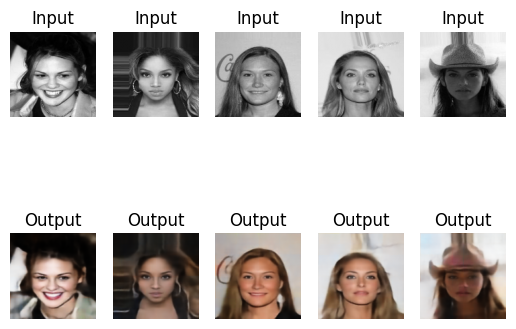

In [27]:

for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(gray[i].squeeze(), cmap='gray')
    plt.title('Input')
    plt.axis('off')


    plt.subplot(2, num_samples, i + 1 + num_samples)
    if outputs.shape[1] == 1:
        plt.imshow(outputs[i].squeeze(), cmap='gray')
    else:
        plt.imshow(outputs[i].permute(1, 2, 0).squeeze())
    plt.title('Output')
    plt.axis('off')

plt.show()

In [28]:
model_save_path = "colorization_autoencoder.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to colorization_autoencoder.pth
